# Graph postprocessing with cause2e
This notebook shows examples of how ```cause2e``` can be used for postprocessing causal graphs. Postprocessing can be performed by the ```discovery.StructureLearner``` after learning the causal graph. The graph class is mostly based on the ```networkx``` package, which unfortunately does not support mixed graphs (directed and undirected edges at the same time), so we added some functionality.

### Imports

In [1]:
import os
from cause2e import path_mgr, discovery, knowledge

## Set up paths to data and output directories
This step is conveniently handled by the ```PathManager``` class, which avoids having to wrestle with paths throughout the multistep causal analysis. If we want to perform the analysis in a directory ```'dirname'``` that contains ```'dirname/data'``` and ```'dirname/output'``` as subdirectories, we can also use ```PathManagerQuick``` for an even easier setup. The experiment name is used for generating output files with meaningful names, in case we want to study multiple scenarios (e.g. with varying model parameters). For this analysis, we use the sprinkler dataset.

In [2]:
cwd = os.getcwd()
wd = os.path.dirname(cwd)
paths = path_mgr.PathManagerQuick(experiment_name='sprinkler',
                                  data_name='sprinkler.csv',
                                  directory=wd
                                  )

## Initialize the StructureLearner
As in the other notebooks, we set up a ```StructureLearner``` and read our data.

In [3]:
learner = discovery.StructureLearner(paths)
learner.read_csv(index_col=0)

The first step in the analysis should be an assessment of which variables we are dealing with. In the sprinkler dataset, each sample tells us 
- the current season
- whether it is raining
- whether our lawn sprinkler is activated
- whether our lawn is slippery
- whether our lawn is wet.

In [4]:
print(learner.variables)

{'Season', 'Rain', 'Wet', 'Sprinkler', 'Slippery'}


It necessary to communicate to the ```StructureLearner``` if the variables are discrete, continuous, or both. We check how many unique values each variable takes on in our sample and deduce that all variables are discrete.

In [5]:
print(learner.data.nunique())

Season       4
Sprinkler    2
Rain         2
Wet          2
Slippery     2
dtype: int64


This information is passed to the ```StructureLearner``` by indicating the exact sets of discrete and continuous variables.

In [6]:
learner.discrete = set(learner.variables)
learner.continuous = set()

### Provide domain knowledge
Humans can often infer parts of the causal graph from domain knowledge. The nodes are always just the variables in the data, so the problem of finding the right graph comes down to selecting the right edges between them.

As a reminder: The correct causal graph has an edge from variable A to variable B if and only if variable A directly influences variable B (changing the value of variable A changes the value of variable B if we keep all other variables fixed).

There are three ways of passing domain knowledge:
- Indicate which edges must be present in the causal graph.
- Indicate which edges must not be present in the causal graph.
- Indicate a temporal order in which the variables have been created. This is then used to generate forbidden edges, since the future can never influence the past.

In this example, we only assume that the current season is directly influencing the weather and the probability that the sprinkler is on. This makes sense: During the summer, it is less likely to rain and sprinklers are more likely to be activated.

In [7]:
required = {('Season', 'Rain'), ('Season', 'Sprinkler')}

We pass the knowledge to the ```StructureLearner``` and check if it has been correctly received.

In [8]:
learner.set_knowledge(required=required)
learner.show_knowledge()

Showing knowledge for graph search.

Required edges:
('Season', 'Rain')
('Season', 'Sprinkler')
--------------------
Forbidden edges:
--------------------
Temporal order:
[]


### Apply a structure learning algorithm
Now that the ```StructureLearner``` has received the data and the domain knowledge, we can try to recover the original graph using causal discovery methods provided by the internally called ```py-causal``` package. There are many parameters that can be tuned (choice of algorithm, search score, independence test, hyperparameters, ...) and we can get an overview by calling some informative methods of the learner. Reasonable default arguments are provided (FGES with CG-BIC score for possibly mixed datatypes and respecting domain knowledge), so we use these for our minimal example.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The graph is fully directed.



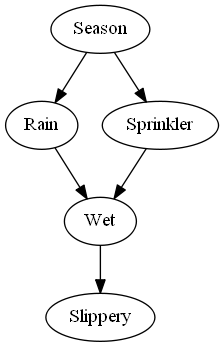

Saving dot file.
Knowledge is respected!
Saving png file.
Knowledge is respected!
Saving svg file.
Knowledge is respected!


In [9]:
learner.run_quick_search()

The output of the search is a proposed causal graph. We can ignore the warning about stopping the Java Virtual Machine (needed by ```py-causal``` which is a wrapper around the ```TETRAD``` software that is written in Java) if we do not run into any problems. If the algorithm cannot orient all edges, we need to do this manually. Therefore, the output includes a list of all undirected edges, so we do not miss them in complicated graphs with many variables and edges. In our case, all the edges are already oriented.

The result seems reasonable:
- The weather depends on the season.
- The sprinkler use also depends on the season.
- The lawn will be wet if it rains or if the sprinkler is activated.
- The lawn will be slippery if it is wet.

We can also see that the result is automatically saved to different file formats and that our graph respects the previously indicated domain knowledge. This is the ideal case where no postprocessing is necessary. But what happens if we are not happy with the results of the search procedure? In order to create such a situation, we enlarge the prescribed domain knowledge by an edge from ```'Wet'``` to ```'Rain'```, which is clearly the wrong causal direction.

In [10]:
required = {('Season', 'Rain'), ('Season', 'Sprinkler'), ('Wet', 'Rain')}
learner.set_knowledge(required=required)
learner.show_knowledge()

Showing knowledge for graph search.

Required edges:
('Season', 'Rain')
('Wet', 'Rain')
('Season', 'Sprinkler')
--------------------
Forbidden edges:
--------------------
Temporal order:
[]


We repeat the search with the updated domain knowledge.

Remember to stop the JVM after you are completely done.
Proposed causal graph:

The following edges are undirected:

Slippery --- Wet
Season --- Wet
Sprinkler --- Wet


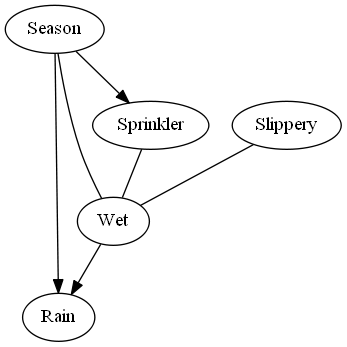

Saving dot file.


AssertionError: Orient all edges before checking for acyclicity!

In [11]:
learner.run_quick_search()

We notice several differences to the last run:
- The result of the search looks completely different.
- There are undirected edges. A list of them is printed.
- The graph cannot be saved.

Let us have a look at what has happened:
- The different search result is a necessary consequence of the enlarged domain knowledge: Since the true graph has an edge from ```Rain``` to ```Wet```, but we prescribed the edge with the opposite orientation, it is not possible to recover the true graph.
- Undirected edges show that the ```StructureLearner``` cannot infer the direction of an edge from the data and domain knowledge. Given that we do not allow the true graph to be found, difficulties in creating a sensible graph with orientations backed by the data are to be expected.
- The graph is only saved automatically after the search if it is a directed acyclic graph that respects the domain knowledge. In our case, the graph is not even fully directed and we get an error message. This check ensures that we do not save faulty graphs without noticing problems that will later on corrupt our causal estimates.

In real application cases with many variables, it is not surprising if the result of the search is not completely satisfactory. Therefore, we show how to postprocess the graph until we arrive at the correct result. The possible postprocessing operations are adding, removing and reversing edges.

The edge between ```'Season'``` and ```'Wet'``` should not be present at all (the true graph shows only an indirect causal effect), so we remove it.

Proposed causal graph:

The following edges are undirected:

Slippery --- Wet
Sprinkler --- Wet


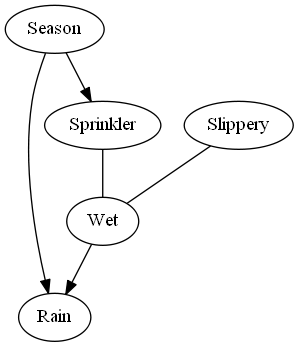

In [12]:
learner.remove_edge('Season', 'Wet', directed=False)

The edge between ```'Sprinkler'``` and ```'Wet'``` should be present, but it lacks the correct orientation. We can fix this by a call to ```add_edge```. Note that we do not need to remove the undirected edge, it is simply overwritten by the new directed edge. This property can be verified by checking the updated list of undirected edges.

Proposed causal graph:

The following edges are undirected:

Slippery --- Wet


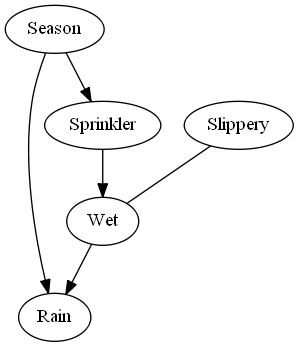

In [13]:
learner.add_edge('Sprinkler', 'Wet')

The same holds true for the edge between ```'Slippery'``` and ```'Wet'```.

Proposed causal graph:

The graph is fully directed.



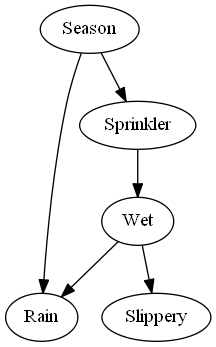

In [14]:
learner.add_edge('Wet', 'Slippery')

Now we only need to fix the error that has caused all the confusion for the search procedure, namely the edge from ```'Wet'``` to ```'Rain'```.

Proposed causal graph:

The graph is fully directed.



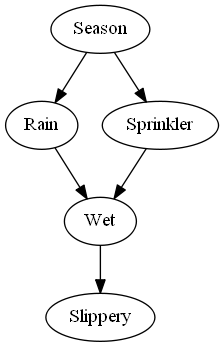

In [15]:
learner.reverse_edge('Rain', 'Wet')

After we have fixed all the bad edges, we can save the graph to different file formats.

In [16]:
learner.save_graphs()

Saving dot file.


AssertionError: Missing edges: {('Wet', 'Rain')}

Oh no! There is still an error message that the edge from ```'Wet'``` to ```'Rain'``` is missing. ```Cause2e``` is strict about respecting domain knowledge because this is how we overcome spurious correlations. In our case, we know that the domain knowledge was wrong, so we can force the learner to save the graph anyway by passing ```strict=False```. The key lesson here is to be diligent when specifying domain knowledge, as is illustrated by all the complications that one misspecified orientation has caused.

In [17]:
learner.save_graphs(strict=False)

Saving dot file.
Saving png file.
Saving svg file.


## Some more postprocessing options
The most important thing in dealing with graphs is having a visualization. By default, the graph is shown whenever we make any changes to it, but we might nonetheless want to call ```display_graph``` to have a look at it without modifying anything.

Proposed causal graph:

The graph is fully directed.



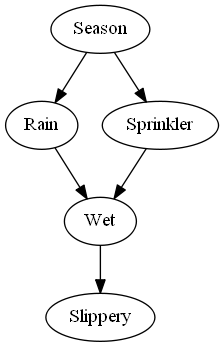

In [18]:
learner.display_graph()

In scenarios with many variables, it can be hard to find nodes or edges in the graph. For this purpose, the ```StructureLearner``` is equipped with the ```has_node``` and ```has_edge methods``` that allow us to query the graph programmatically instead of visually.

In [19]:
print(learner.has_node('Country'))
print(learner.has_node('Sprinkler'))

False
True


For inspecting edges, not only source and destination node, but also whether an edge is directed is important information.

In [20]:
print(learner.has_edge('Season', 'Rain'))
print(learner.has_edge('Season', 'Rain', directed=False))

True
False


In case we see that a variable is missing in the graph, we can implicitly add it by creating an edge to another variable. This can happen if a variable is unmeasured (not contained in the data set that was used for learning the graph) or if we have simply forgotten about it and want to include it in postprocessing, e.g. for subsequent discussions that rely on the causal graph as a means of communicating our assumptions.

Proposed causal graph:

The graph is fully directed.



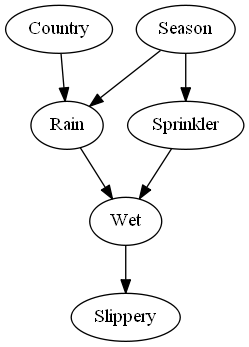

In [21]:
learner.add_edge('Country', 'Rain')

As we have seen at our first attempt at saving the graph, ```cause2e``` can check whether a causal graph conforms to the previously communicated domain knowledge. Outside of a saving procedure, this functionality can be accessed explicitly via the ```respects_knowledge``` method.

In [22]:
required = {('Season', 'Rain'), ('Season', 'Sprinkler')}
learner.set_knowledge(required=required)
print(learner.respects_knowledge())

Knowledge is respected!
True


In the same way, we can directly check the graph for acyclicity by calling the ```is_acyclic``` method, and for undirected edges by calling the ```has_undirected_edges``` method.

In [23]:
print(learner.is_acyclic())
print(learner.has_undirected_edges())

True
False
